## Part 1: Import statements

In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from collections import Counter

import tensorflow
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding,GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution1D as Conv1D, InputLayer, concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Part 2: Importing cleaned data

In [84]:
data = pd.read_csv("Data/processed_data.csv", index_col=0)
data = data.dropna()
data

,tweet,class
0,woman shouldnt complain cleaning house man alw...,2
1,boy dats coldtyga dwn bad cuffin dat hoe place,1
2,dawg ever fuck bitch stato cry confused shit,1
3,look like tranny,1
4,shit hear might true might faker bitch told ya,1
...,...,...
25291,yous muthafin lie right tl trash mine bible sc...,1
25292,youve gone broke wrong heababy drove redneck c...,2
25294,young buck wan na eat dat nigguh like aint fuc...,1
25295,youu got wild bitches tellin lies,1


In [85]:
number_tweets = len(data["tweet"])
print(f"Number of sentences: {number_tweets}")

Number of sentences: 23865


## Part 3: Splitting Data

In [86]:

#splitting the data into train, validation, test
X, X_test, y, y_test = train_test_split(data['tweet'], data['class'],  test_size=0.2, random_state=42)

In [87]:
#splitting the data into train and validation
X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size = 0.25,train_size =0.75, random_state=42)

In [88]:
X_train.sample(5)

23265                                   wheres money bitch
23959                               youre irrelevant bitch
2369                   wonder charlie brown would say days
11517    im already tired mr stupid af decides show us ...
24132    bitch probably mollyd nigga said good mornin back
Name: tweet, dtype: object

## Checking vocabulary size

Count Vectorization to check vocabulary size

In [89]:
#Count Vectorizing the X_train
count_vec = CountVectorizer()
count_vec.fit(X_train)

X_train_count = count_vec.transform(X_train)
X_train_count = X_train_count.toarray()

#Count Vectorizing the X_cv
X_cv_count = count_vec.transform(X_cv)
X_cv_count = X_cv_count.toarray()

#Count Vectorizing the X_test
X_test_count = count_vec.transform(X_test)
X_test_count = X_test_count.toarray()

count_vec.vocabulary_

{'stop': 13309,
 'spoiling': 12986,
 'fags': 4628,
 'wcw': 15221,
 'babes': 805,
 'love': 8196,
 'thse': 14058,
 'sexy': 12145,
 'bitches': 1302,
 'bestfriend': 1181,
 'babe': 804,
 'yanks': 15762,
 'coming': 2736,
 'disparagement': 3764,
 'pride': 10705,
 'rather': 11121,
 'jack': 7110,
 'fuck': 5249,
 'hoes': 6379,
 'tbh': 13780,
 'shit': 12260,
 'boring': 1545,
 'give': 5558,
 'wife': 15449,
 'lmfao': 8072,
 'little': 8038,
 'like': 7968,
 'message': 8649,
 'hoe': 6363,
 'need': 9246,
 'plan': 10391,
 'stuff': 13400,
 'thats': 13929,
 'saying': 11886,
 'ive': 7100,
 'pinto': 10352,
 'since': 12441,
 'dude': 4065,
 'iphone': 7026,
 'beginning': 1107,
 'gerryshalloweenparty': 5478,
 'halloween': 5985,
 'yesterday': 15833,
 'stupid': 13412,
 'nigger': 9376,
 'youre': 15879,
 'dismissed': 3761,
 'bitch': 1290,
 'wan': 15127,
 'na': 9137,
 'play': 10412,
 'thumper': 14070,
 'tounge': 14276,
 'punching': 10878,
 'smelly': 12671,
 'turtle': 14530,
 'pussy': 10907,
 'lady': 7669,
 'next': 9

In [9]:
print(f"Number of words in vocabulary: {len(count_vec.vocabulary_)}")

Number of words in vocabulary: 15973


## Tokenization

In [90]:
tokenizer = Tokenizer()

#fitting tokenizer on training set
tokenizer.fit_on_texts(X_train)

#encoding training data
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_cv = tokenizer.texts_to_sequences(X_cv)
encoded_test = tokenizer.texts_to_sequences(X_test)

#padding sequences using the maximum sequence of the training set
max_length = max([len(sentence.split()) for sentence in X_train])


X_train_tk = pad_sequences(encoded_train,maxlen = max_length, padding = "post" )
X_cv_tk =pad_sequences(encoded_cv,maxlen = max_length, padding = "post" )
X_test_tk =pad_sequences(encoded_test,maxlen = max_length, padding = "post" )

In [91]:
vocab_size = len(tokenizer.word_index)+1

In [217]:

def oversample(X_train, y_train):
    print("Before Oversampling: {}".format(Counter(y_train)))

    # # define oversampling strategy
    oversample = RandomOverSampler(sampling_strategy='all')

    # # fit and apply the transform
    X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
    print("After Oversampling: {}".format(Counter(y_train_over)))
    
    return X_train_over, y_train_over

In [218]:
X_train_tk_over, y_train_over = oversample(X_train_tk, y_train)
# X_train_tk_over, y_train_over = X_train_tk, y_train


Before Oversampling: Counter({1: 11062, 2: 2437, 0: 820})
After Oversampling: Counter({1: 11062, 2: 11062, 0: 11062})


In [219]:
#  encoding target variable
y_train_over_encoded = to_categorical(y_train_over,3)
y_cv_encoded = to_categorical(y_cv,3)
y_test_encoded = to_categorical(y_test,3)


In [220]:
y_train_over_encoded

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## Print Model statistics

In [207]:
def printModelStats(y_preds, y_test):
    print(classification_report(y_test, y_preds, target_names = ['Hate', 'Offensive', 'Neither']))
   
    cm = confusion_matrix(y_test, y_preds)
    print("The confusion matrix:")
    print(cm)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    sns.heatmap((cm_percent), annot = True, cmap = "Blues").set(title ="Confusion Matrix Expressed in %")

In [208]:
def printResults(history):
    results = pd.DataFrame(history.history)
    return results

In [209]:
def plotLossCurves(history):
    results = pd.DataFrame(history.history)
    
    plt.figure(figsize = (10,5))
    plt.plot(results.index, results.loss)
    plt.plot(results.index, results.val_loss)
    plt.title("CNN with trained embeddings")
    plt.xlabel("Epochs")
    plt.ylabel("Categorical Crossentropy Loss")
    plt.legend(["Training Loss", "Validation Loss"])
    plt.show()

In [210]:
def plotAccuracyCurves(history):
    results = pd.DataFrame(history.history)
    
    plt.figure(figsize = (10,5))
    plt.plot(results.index, results.accuracy)
    plt.plot(results.index, results.val_accuracy)
    plt.title("CNN with trained embeddings")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Training Accuracy", "Validation Accuracy"])
    plt.show()

## CNN with custom word embedding

Simple 1D Convolutional neural network to capture the sequence of words 
- inspired by: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [237]:
# model1 = Sequential()
# model1.add(Embedding(input_dim= vocab_size, output_dim = 100, input_length = max_length))
# model1.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))
# model1.add(GlobalMaxPooling1D()) #pooling to downsample feature extraction
# model1.add(Flatten())
# model1.add(Dense(64, activation='relu'))
# model1.add(Dense(32, activation='relu'))
# model1.add(Dense(3, activation='softmax'))
# print(model1.summary())


# model1 = Sequential()
# model1.add(Embedding(vocab_size, 100, input_length = max_length))
# model1.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))##filter size 128
# model1.add(MaxPooling1D(pool_size=3)) #pooling to downsample feature extraction
# model1.add(Conv1D(filters = 128, kernel_size = 4, activation = 'relu'))
# model1.add(MaxPooling1D(pool_size=3))
# model1.add(Conv1D(filters = 128, kernel_size = 3, activation = 'relu'))
# model1.add(MaxPooling1D(pool_size=3))
# model1.add(Flatten())
# model1.add(Dense(10, activation ='relu', kernel_regularizer=l2(0.01))) #weight 0.01
# model1.add(Dropout(0.5))
# model1.add(Dense(3, activation = "softmax"))
# print(model1.summary())

# ****
# model1 = Sequential()
# model1.add(Embedding(vocab_size, 100, input_length = max_length))
# model1.add(Conv1D(filters = 32, kernel_size = 8, activation = 'relu'))
# model1.add(MaxPooling1D(pool_size=2)) #pooling to downsample feature extraction
# model1.add(Flatten())
# model1.add(Dense(10, activation ='relu', kernel_regularizer=l2(0.01)))
# model1.add(Dropout(0.5))
# model1.add(Dense(3, activation = "softmax"))
# model1.summary()

# optimizer = tensorflow.optimizers.Adam(lr=0.0001)
# model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
# callbacks_list = [early_stopping]

# print(model1.summary())


In [294]:
# #Model 1

num_filters = 64
output_dimension = 100
kernel_size = 8


def createCNN1(num_filters, output_dimension):
    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length)(input)
    
    convolution = Conv1D(filters = num_filters, kernel_size = kernel_size, activation = 'relu')(embedding_layer)
    pooling = MaxPooling1D(pool_size=2)(convolution) #pooling to downsample feature extraction
    flatten = Flatten()(pooling)
    dense_1 = Dense(10, activation ='relu', kernel_regularizer=l2(0.01)) (flatten)
    dropout = Dropout(0.5)(dense_1)
    output = Dense(3, activation = "softmax") (dropout)

    model1 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.0001)
    model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model1.summary()

    return model1


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

In [295]:
model1 = createCNN1(num_filters, output_dimension)


Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 127)]             0         
                                                                 
 embedding_44 (Embedding)    (None, 127, 100)          1599200   
                                                                 
 conv1d_65 (Conv1D)          (None, 120, 64)           51264     
                                                                 
 max_pooling1d_65 (MaxPooli  (None, 60, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_41 (Flatten)        (None, 3840)              0         
                                                                 
 dense_73 (Dense)            (None, 10)                38410     
                                                          

In [296]:

history = model1.fit(X_train_tk_over, y_train_over_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded), callbacks = callbacks_list) #, callbacks=callbacks_list



Epoch 1/10
519/519 [==============================] - 26s 48ms/step - loss: 1.0198 - accuracy: 0.4434 - val_loss: 0.9429 - val_accuracy: 0.4308
Epoch 2/10
519/519 [==============================] - 28s 53ms/step - loss: 0.9046 - accuracy: 0.5466 - val_loss: 0.8315 - val_accuracy: 0.7098
Epoch 3/10
519/519 [==============================] - 27s 52ms/step - loss: 0.8696 - accuracy: 0.6058 - val_loss: 0.8028 - val_accuracy: 0.7850
Epoch 4/10
519/519 [==============================] - 28s 54ms/step - loss: 0.8529 - accuracy: 0.6298 - val_loss: 0.8015 - val_accuracy: 0.8049
Epoch 5/10
519/519 [==============================] - 28s 55ms/step - loss: 0.8326 - accuracy: 0.6442 - val_loss: 0.8095 - val_accuracy: 0.8165
Epoch 6/10
519/519 [==============================] - 28s 55ms/step - loss: 0.8288 - accuracy: 0.6468 - val_loss: 0.8192 - val_accuracy: 0.8150
Epoch 6: early stopping


evaluation

In [297]:
loss,acc = model1.evaluate(X_cv_tk, y_cv_encoded)


150/150 [==============================] - 1s 6ms/step - loss: 0.8192 - accuracy: 0.8150


In [298]:
printResults(history)

,loss,accuracy,val_loss,val_accuracy
0,1.019797,0.443380,0.942895,0.430756
1,0.904557,0.546556,0.831465,0.709826
2,0.869594,0.605767,0.802835,0.785041
3,0.852888,0.629844,0.801521,0.804944
4,0.832584,0.644157,0.809523,0.816468
5,0.828804,0.646839,0.819238,0.815001


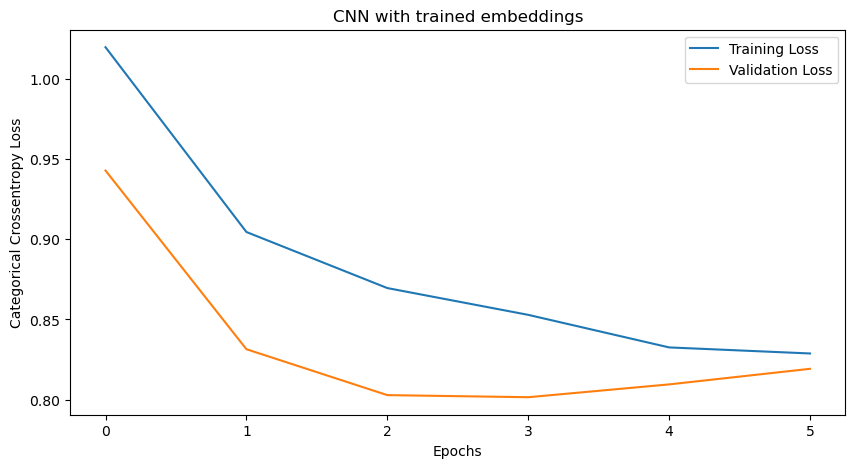

In [299]:
plotLossCurves(history)

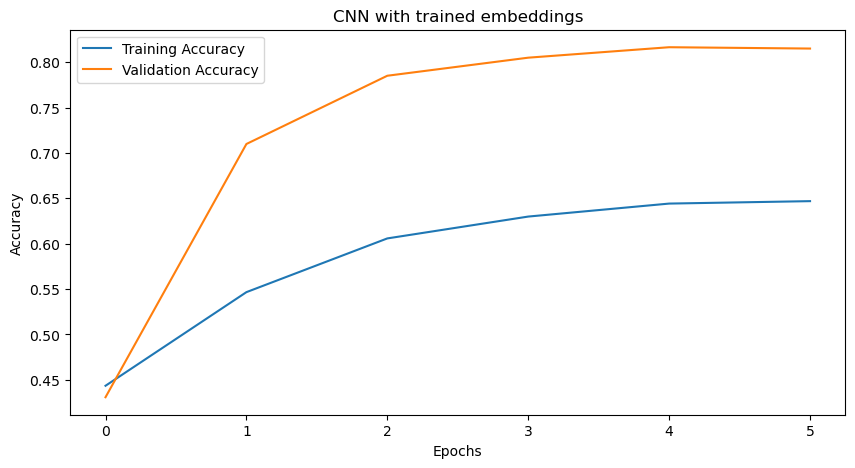

In [300]:
plotAccuracyCurves(history)

150/150 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

        Hate       0.27      0.41      0.33       269
   Offensive       0.89      0.88      0.89      3670
     Neither       0.76      0.65      0.70       834

    accuracy                           0.82      4773
   macro avg       0.64      0.65      0.64      4773
weighted avg       0.83      0.82      0.82      4773

The confusion matrix:
[[ 111  137   21]
 [ 281 3241  148]
 [  22  274  538]]


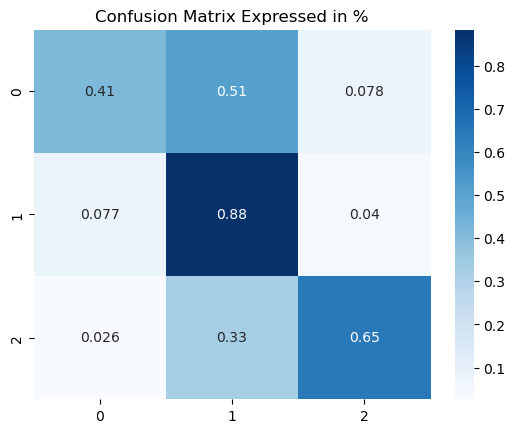

In [301]:
y_pred = model1.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)

printModelStats(predicted_categories, true_categories)

# grid search (normal model)


# then lstm

## Grid Search

## Yoon Kim (2014) inspired model 

In Yoon Kim "Convolutional Neural Networks for Sentence Classification", Kim uses a relatively simple CNN for sentence classification and receives great results. Specifically, he uses:
 - embedding dimension of 300 (output_dim)
 - 3 concatenated 1D convolutional layers with kernel sizes of 3,4,5 respectively and ReLu activation
 - 100 filters in each convolutional layer
 - 3 MaxPooling layers
 - A dropout layer of p=0.5
 - L2 regularization with weight of 3

Using these facts, a model was developed and finetuned

Code inspired by:
- https://www.kaggle.com/code/kakiac/deep-learning-4-text-classification-cnn-bi-lstm#CNN-&-Word2Vec-Implementation
- https://www.kaggle.com/code/hamishdickson/cnn-for-sentence-classification-by-yoon-kim#%C2%A0Model-2:-Static-word2vec


In [308]:
kernel_sizes = [3,4,5]
convolutions = []
num_filters = 128
output_dimension = 300

def createCNN2(vocab_size, max_length, output_dimension, num_filters, kernel_sizes):
    
    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length)(input)

    convolutions = []
    for size in kernel_sizes:
        conv_layer = Conv1D(filters=num_filters, kernel_size=size, activation="relu")(embedding_layer) ##, kernel_regularizer=l2(3)
        pooling = MaxPooling1D(pool_size=3)(conv_layer)
        convolutions.append(pooling)
    
    conv_merged = concatenate(convolutions, axis=1)

    dropout = Dropout(0.5)(conv_merged)
    flatten = Flatten()(dropout)
    output = Dense(3, activation="softmax")(flatten)

    model2 = Model(inputs=input, outputs=output)
    model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model2.summary()

    return model2


In [309]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

model2 = createCNN2(vocab_size, max_length, output_dimension, num_filters, kernel_sizes)


Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_34 (InputLayer)       [(None, 127)]                0         []                            
                                                                                                  
 embedding_47 (Embedding)    (None, 127, 300)             4797600   ['input_34[0][0]']            
                                                                                                  
 conv1d_72 (Conv1D)          (None, 125, 128)             115328    ['embedding_47[0][0]']        
                                                                                                  
 conv1d_73 (Conv1D)          (None, 124, 128)             153728    ['embedding_47[0][0]']        
                                                                                           

In [310]:
history2 = model2.fit(X_train_tk_over, y_train_over_encoded, epochs =10, batch_size=50, validation_data = (X_cv_tk, y_cv_encoded), callbacks = callbacks_list)


Epoch 1/10
664/664 [==============================] - 137s 205ms/step - loss: 0.2762 - accuracy: 0.8930 - val_loss: 0.4819 - val_accuracy: 0.8747
Epoch 2/10
664/664 [==============================] - 143s 216ms/step - loss: 0.0353 - accuracy: 0.9897 - val_loss: 0.6736 - val_accuracy: 0.8781
Epoch 3/10
664/664 [==============================] - 262s 394ms/step - loss: 0.0110 - accuracy: 0.9973 - val_loss: 0.8069 - val_accuracy: 0.8728
Epoch 4/10
664/664 [==============================] - 143s 215ms/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 0.9145 - val_accuracy: 0.8640
Epoch 4: early stopping


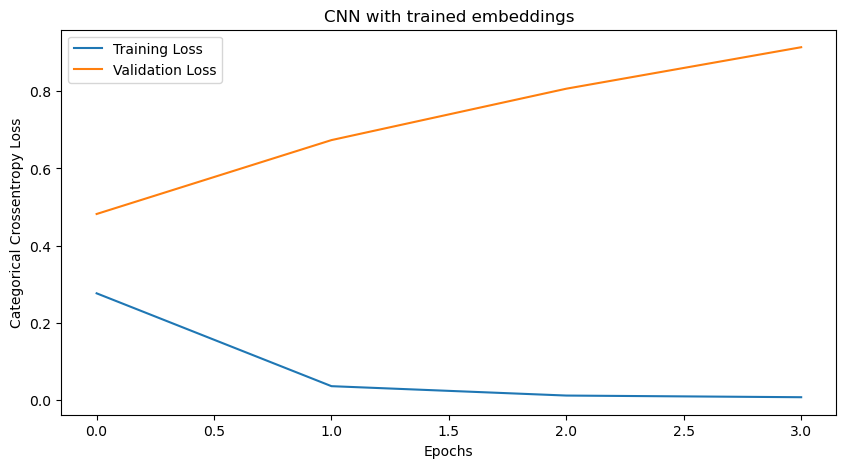

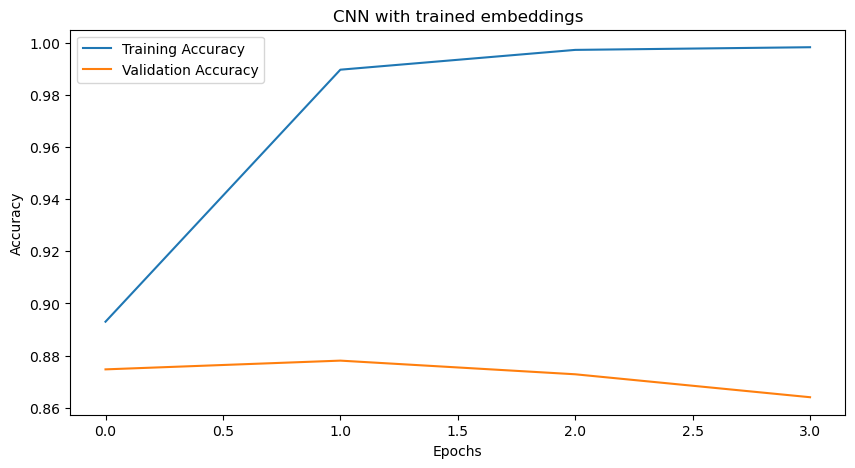

In [311]:
printResults(history2)
plotLossCurves(history2)
plotAccuracyCurves(history2)

150/150 [==============================] - 5s 35ms/step
              precision    recall  f1-score   support

        Hate       0.29      0.27      0.28       280
   Offensive       0.91      0.92      0.92      3715
     Neither       0.81      0.76      0.78       778

    accuracy                           0.86      4773
   macro avg       0.67      0.65      0.66      4773
weighted avg       0.86      0.86      0.86      4773

The confusion matrix:
[[  76  186   18]
 [ 163 3432  120]
 [  22  165  591]]


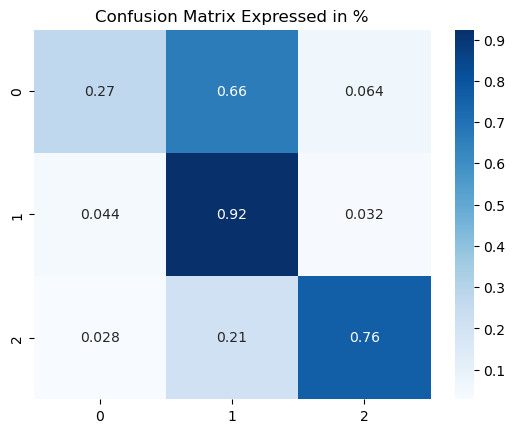

In [312]:
y_pred = model2.predict(X_test_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_test_encoded,axis = 1)


printModelStats(predicted_categories, true_categories)

## CNN with pretrained embedding: Word2Vec

## CNN with pretrained embedding: word2vec

## Parameter search